# RUL Time Prediction for Turbofan Engine

## 1. Explaining the data set

- Engine degradation simulation was carried out for run-to-failure using C-MAPSS (Commercial Modular Aero-Propulsion System Simulation). 
 
- Four different data sets simulated under different combinations of operational conditions and fault modes. 
 
- Records several sensor channels to characterize fault evolution.

- The data sets consists of multivariate time series signals.

- There are 100 engines are considered in data set FD001. Each of the engines is operating normally at the start of each time series and develops a fault at some point during the series. The fault grows in magnitude until the system failure. 

- Each record in run-to-failure trajectories, which corresponds to a given operation cycle, is a 24-element vector, consists of three values for the operational settings and 21 values for engine performance measurements, which are contaminated with noise.

- All failures are caused by High-Pressure Compressor (HPC) degradation. 

- For computational convenience, each three cycles are considered as one-time unit. The results are finally super imposed to original cycle numbers.


In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import random
import importlib
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Loading the data set

columns = ['unit_nr', 'time', 'opset_1', 'opset_2', 'opset_3']
columns += ['sensor_{0:02d}'.format(s + 1) for s in range(21)]

df = pd.read_excel("train_FD001.xlsx", names = columns, header = None)
df_val = pd.read_excel("test_FD001.xlsx", names = columns, header = None)
RUL_1 = pd.read_excel("RUL_FD001.xlsx", names = ['RUL'], header = None)

In [3]:
df.shape

(20631, 26)

In [4]:
df['unit_nr'].nunique()

100

In [5]:
df.head(3)

unit_nr  time  opset_1  opset_2  opset_3  sensor_01  sensor_02  sensor_03  \
0        1     1  -0.0007  -0.0004      100     518.67     641.82    1589.70   
1        1     2   0.0019  -0.0003      100     518.67     642.15    1591.82   
2        1     3  -0.0043   0.0003      100     518.67     642.35    1587.99   

   sensor_04  sensor_05  ...  sensor_12  sensor_13  sensor_14  sensor_15  \
0    1400.60      14.62  ...     521.66    2388.02    8138.62     8.4195   
1    1403.14      14.62  ...     522.28    2388.07    8131.49     8.4318   
2    1404.20      14.62  ...     522.42    2388.03    8133.23     8.4178   

   sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0       0.03        392       2388        100      39.06    23.4190  
1       0.03        392       2388        100      39.00    23.4236  
2       0.03        390       2388        100      38.95    23.3442  

[3 rows x 26 columns]

In [3]:
# Data Preprocessing

# Adding new column for RUL time for each unit

mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']


In [8]:
df['RUL'].max()

361

In [9]:
df.iloc[:,2:26].head()

opset_1  opset_2  opset_3  sensor_01  sensor_02  sensor_03  sensor_04  \
0  -0.0007  -0.0004      100     518.67     641.82    1589.70    1400.60   
1   0.0019  -0.0003      100     518.67     642.15    1591.82    1403.14   
2  -0.0043   0.0003      100     518.67     642.35    1587.99    1404.20   
3   0.0007   0.0000      100     518.67     642.35    1582.79    1401.87   
4  -0.0019  -0.0002      100     518.67     642.37    1582.85    1406.22   

   sensor_05  sensor_06  sensor_07  ...  sensor_12  sensor_13  sensor_14  \
0      14.62      21.61     554.36  ...     521.66    2388.02    8138.62   
1      14.62      21.61     553.75  ...     522.28    2388.07    8131.49   
2      14.62      21.61     554.26  ...     522.42    2388.03    8133.23   
3      14.62      21.61     554.45  ...     522.86    2388.08    8133.83   
4      14.62      21.61     554.00  ...     522.19    2388.04    8133.80   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0     8.4195       0.03        392       2388        100      39.06    23.4190  
1     8.4318       0.03        392       2388        100      39.00    23.4236  
2     8.4178       0.03        390       2388        100      38.95    23.3442  
3     8.3682       0.03        392       2388        100      38.88    23.3739  
4     8.4294       0.03        393       2388        100      38.90    23.4044  

[5 rows x 24 columns]

In [4]:
# Scaling the features

scaler = MinMaxScaler()
ndf = df.copy()
ndf.iloc[:,2:26] = scaler.fit_transform(ndf.iloc[:,2:26])

ndf_val = df_val.copy()
ndf_val.iloc[:,2:26] = scaler.fit_transform(ndf_val.iloc[:,2:26])

In [11]:
ndf_val.head()

unit_nr  time  opset_1   opset_2  opset_3  sensor_01  sensor_02  sensor_03  \
0        1     1  0.65625  0.692308      0.0        0.0   0.596215   0.421968   
1        1     2  0.34375  0.230769      0.0        0.0   0.182965   0.504025   
2        1     3  0.53125  0.538462      0.0        0.0   0.419558   0.464814   
3        1     4  0.77500  0.461538      0.0        0.0   0.413249   0.391587   
4        1     5  0.60000  0.461538      0.0        0.0   0.435331   0.471306   

   sensor_04  sensor_05  ...  sensor_12  sensor_13  sensor_14  sensor_15  \
0   0.282214        0.0  ...   0.534247   0.325581   0.152259   0.347076   
1   0.225240        0.0  ...   0.634703   0.395349   0.277907   0.227709   
2   0.346130        0.0  ...   0.591324   0.325581   0.192892   0.533557   
3   0.449867        0.0  ...   0.456621   0.372093   0.217896   0.282359   
4   0.357974        0.0  ...   0.632420   0.325581   0.187891   0.337009   

   sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0        0.0      0.375        0.0        0.0   0.500000   0.620099  
1        0.0      0.500        0.0        0.0   0.645455   0.645718  
2        0.0      0.500        0.0        0.0   0.700000   0.681104  
3        0.0      0.250        0.0        0.0   0.627273   0.620382  
4        0.0      0.125        0.0        0.0   0.618182   0.676008  

[5 rows x 26 columns]

## 2. Performing exploratory statistical analysis on the data set

Pearson correlation coefficient (PCC):

- PCC is a measure of the linear correlation between two variables X and Y.

\begin{equation}
    \rho(X,Y)=\frac{cov(X,Y)}{\sigma X \sigma Y} 
\end{equation}

Please note that:

 * Positive Correlation:  Both variables change in the same direction.
  
 * Neutral Correlation:   No relationship in the change of the variables.

 * Negative Correlation:  Variables change in opposite directions.

In [12]:
ndf.columns

Index(['unit_nr', 'time', 'opset_1', 'opset_2', 'opset_3', 'sensor_01',
       'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06',
       'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'RUL'],
      dtype='object')

In [13]:
corr = ndf.copy()

del corr['unit_nr']
del corr['RUL']
corr.set_index('time', inplace=True)
corr.dropna(axis = 1, how = 'all', inplace = True)

corr = corr.corr(method = 'pearson')
corr2 = pd.DataFrame(np.tril(corr.values), columns = corr.columns, index = corr.index)

correlating = []
for col in corr2.columns:
    ser = corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c.round(2)))

print('highly correlating measurements:')
for c in correlating:
    print(c) 

highly correlating measurements:
('sensor_04', 'sensor_11', 0.83)
('sensor_04', 'sensor_12', -0.82)
('sensor_07', 'sensor_11', -0.82)
('sensor_07', 'sensor_12', 0.81)
('sensor_08', 'sensor_13', 0.83)
('sensor_09', 'sensor_14', 0.96)
('sensor_11', 'sensor_12', -0.85)


It means that:
-  If c value is positive with highly correlating measurement, the sensors are nearly co-linear each other. 
-  Otherwise if it is negative, the sensors are strong inversely colinear.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B40142470>,
      dtype=object)

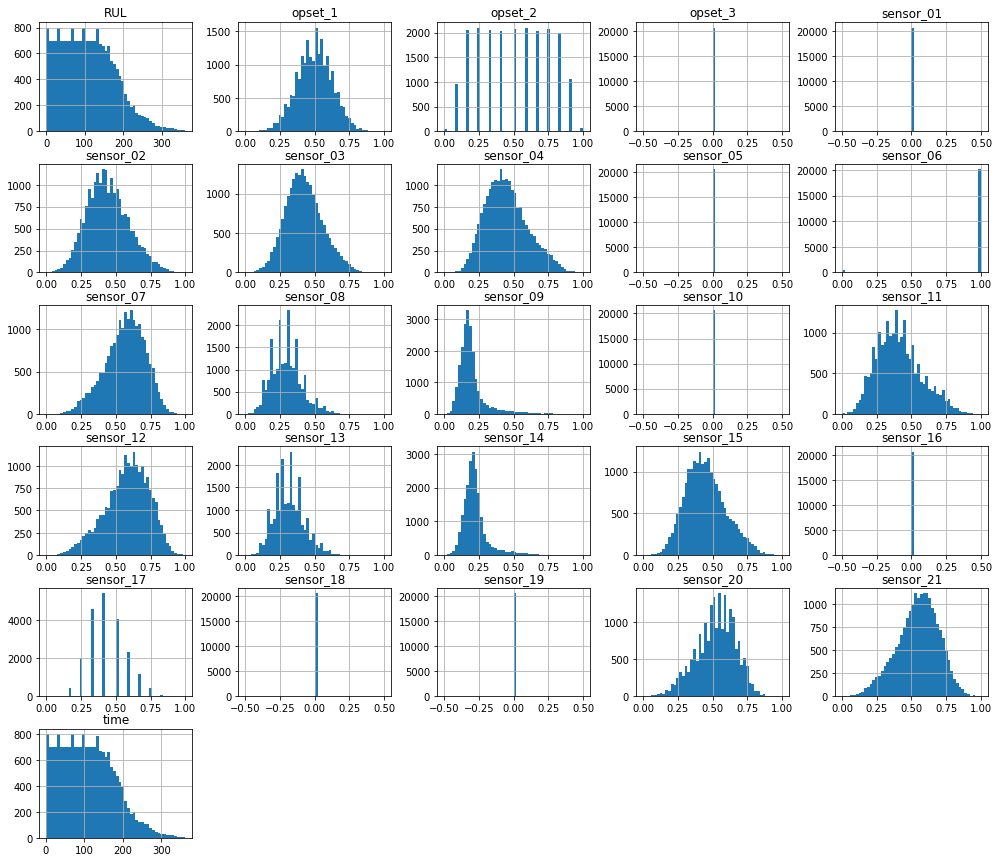

In [14]:
ndf.iloc[:,1:].hist(bins=50, figsize=(17,15))

In [15]:
df2 = pd.DataFrame(df.describe().transpose())
df2[df2['min']-df2['max'] == 0]

count     mean           std      min      25%      50%      75%  \
opset_3    20631.0   100.00  0.000000e+00   100.00   100.00   100.00   100.00   
sensor_01  20631.0   518.67  6.537152e-11   518.67   518.67   518.67   518.67   
sensor_05  20631.0    14.62  3.394700e-12    14.62    14.62    14.62    14.62   
sensor_10  20631.0     1.30  4.660829e-13     1.30     1.30     1.30     1.30   
sensor_16  20631.0     0.03  1.556432e-14     0.03     0.03     0.03     0.03   
sensor_18  20631.0  2388.00  0.000000e+00  2388.00  2388.00  2388.00  2388.00   
sensor_19  20631.0   100.00  0.000000e+00   100.00   100.00   100.00   100.00   

               max  
opset_3     100.00  
sensor_01   518.67  
sensor_05    14.62  
sensor_10     1.30  
sensor_16     0.03  
sensor_18  2388.00  
sensor_19   100.00

In [5]:
#Excluding non effective sensors from the data set

cols_nan = ndf.columns[ndf.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(ndf[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

ndf = ndf.drop(columns=cols_const + cols_nan)
ndf_val = ndf_val.drop(columns=cols_const + cols_nan)

Columns with all nan: 
[]

Columns with all const values: 
['opset_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']



* We need to exclude these features, which are opset_3, sensor_01, sensor_05, sensor_06, sensor_10, sensor_16, sensor_18, sensor_19 from our training data set. 

* In time-series, this is called a flat line, which means there is no activity, possibly caused by sensor malfunctioning.

## 3. Performing basic data visualization techniques on the dataset 

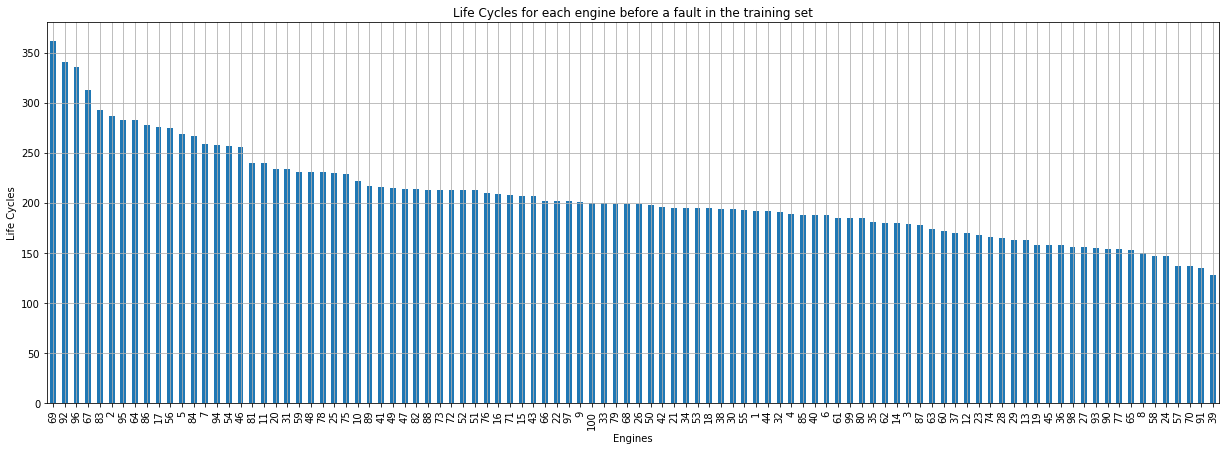

In [9]:
# Life Cycles for each engine before a fault in the training set in descending order
ax = ndf.unit_nr.value_counts().plot.bar(figsize=(21,7))
plt.title("Life Cycles for each engine before a fault in the training set")
ax.set_xlabel("Engines")
ax.set_ylabel("Life Cycles")
ax.grid()

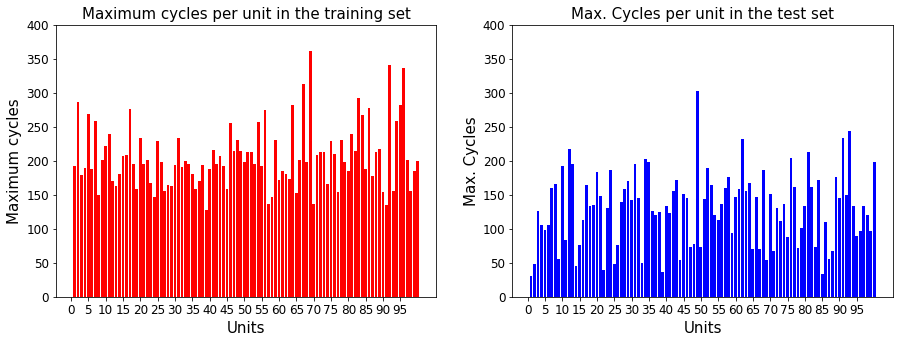

In [10]:
train_cycles = df.groupby('unit_nr', as_index = False)['time'].max()
test_cycles = df_val.groupby('unit_nr', as_index = False)['time'].max()
fig = plt.figure(figsize = (15,5))
fig.add_subplot(1,2,1)
bar_labels = list(train_cycles['unit_nr'])
bars = plt.bar(list(train_cycles['unit_nr']), train_cycles['time'], color = 'red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize = 15)
plt.ylabel('Maximum cycles', fontsize = 15)
plt.title('Maximum cycles per unit in the training set', fontsize = 15)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize = 12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(test_cycles['unit_nr']), test_cycles['time'], color = 'blue')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize = 15)
plt.ylabel('Max. Cycles', fontsize = 15)
plt.title('Max. Cycles per unit in the test set', fontsize = 15)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

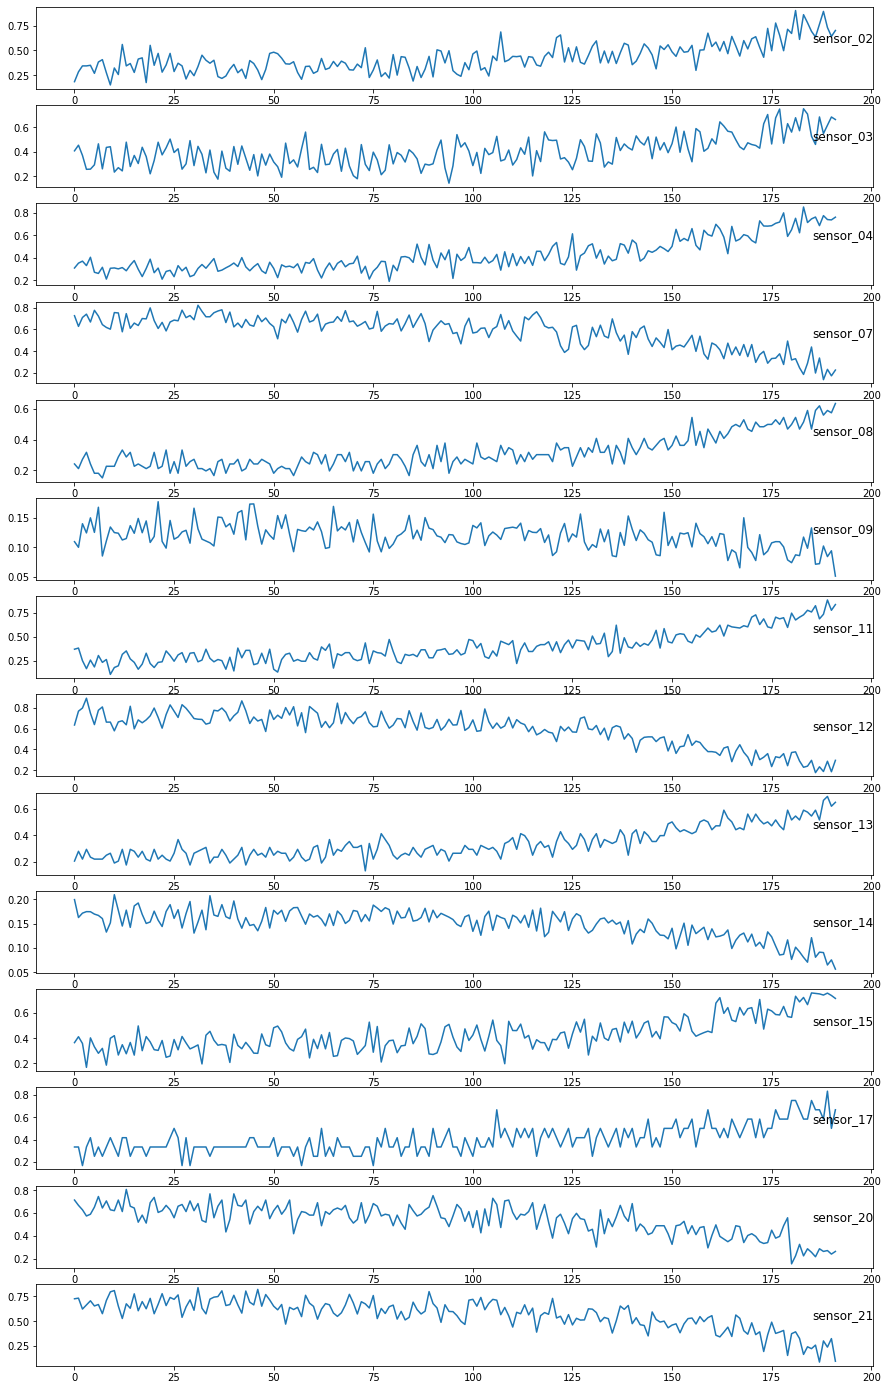

In [11]:
# Visualization of sensors of first engine

values = ndf[ndf.unit_nr == 1].values
groups = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
i = 1
plt.figure(figsize=(15,25))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(ndf.columns[group], y = 0.5, loc = 'right')
    i += 1
plt.show()

Comparing engine 21 and  61 under the same sensor:


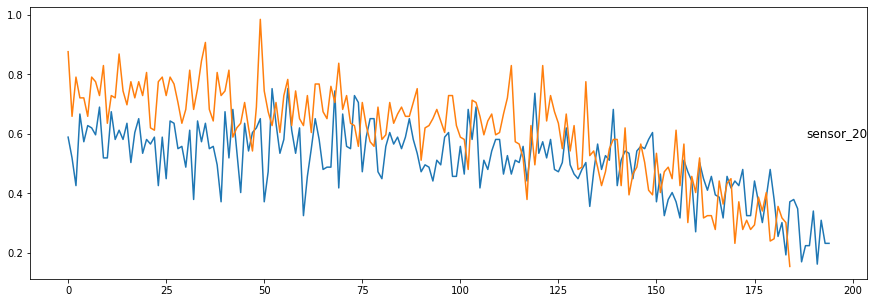

In [15]:
# Comparing the different engines under the same sensor by selecting randomly for intuition

values=[]
groups = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
from random import randint
unit1 = randint(1, 100)
unit2 = randint(1, 100)
values1 = ndf[ndf.unit_nr == unit1].values
values2 = ndf[ndf.unit_nr == unit2].values
b = randint(0, len(groups)-1) 
a = groups[b]
print("Comparing engine{0:3d} and {1:3d} under the same sensor:".format(unit1, unit2))
plt.figure(figsize=(15,5))
plt.plot(values1[:, a])
plt.title(ndf.columns[a], y = 0.5, loc = 'right')
plt.plot(values2[:, a])
plt.title(ndf.columns[a], y = 0.5, loc = 'right')
plt.show()    

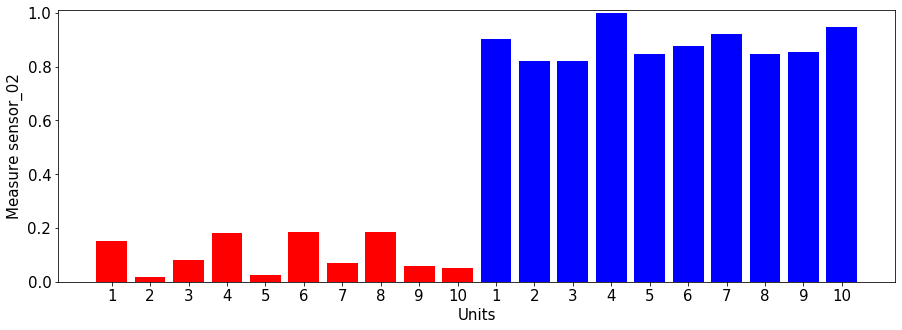

In [9]:
# for sensor_02

minb = ndf.groupby('unit_nr', as_index = False).min().head(10)
maxb = ndf.groupby('unit_nr', as_index = False).max().head(10)

table = minb.append(maxb, ignore_index=True)

fig = plt.figure(figsize = (15,5))

col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis = 0)
bar_labels = list(table['unit_nr'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, table['sensor_02'], color = col)
plt.ylim([0, 1.01])
plt.xlabel('Units', fontsize = 15)
plt.ylabel('Measure sensor_02', fontsize = 15)
plt.xticks(x_pos, bar_labels, fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


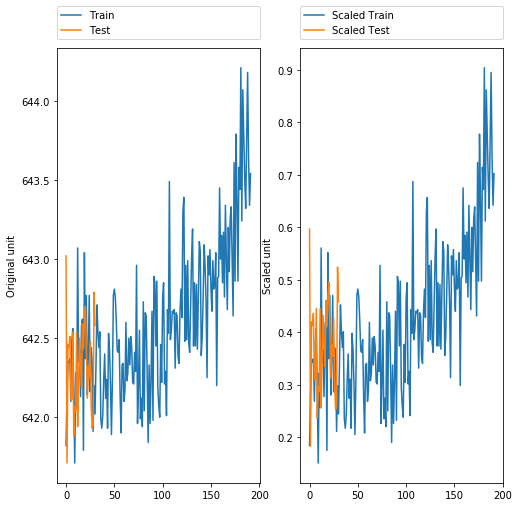

In [18]:
#To ensure that the data are similar after scaling
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(df[df.unit_nr == 1].sensor_02)
plt.plot(df_val[df_val.unit_nr == 1].sensor_02)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc = 3, mode = "expand", borderaxespad = 0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ndf[ndf.unit_nr == 1].sensor_02)
plt.plot(ndf_val[ndf_val.unit_nr == 1].sensor_02)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor = (0., 1.02, 1., .102), loc = 3, mode = "expand", borderaxespad = 0)
plt.ylabel('Scaled unit')
plt.show()

### Reducing noise

* Optimizing rolling feature engineering for time series data.

* Machines are instrumented with multiple in-built sensors to record various measurements while it is in operation. 

* The raw sensor data into meaningful data that can be leveraged for machine learning applications to provide value back to the business. 

* In here, we can simply smooth our data by way of averaging the sensor output samples.

In [10]:
def rolling_mean_by_unit(df, n, verbose=False):
    cols_sensors = [c for c in df.columns if c.startswith('sensor')]
    df_new = ndf.copy()
    unit_nrs = ndf['unit_nr'].unique()
    
    for nr in unit_nrs:
        if verbose:
            print('processing unit nr: {}'.format(nr))
        idx = ndf['unit_nr'] == nr
        df_new.loc[idx, cols_sensors] = ndf.loc[idx, cols_sensors].rolling(n, min_periods=1).mean()
    return df_new

df_old = ndf.copy()
ndf = rolling_mean_by_unit(ndf, 10)

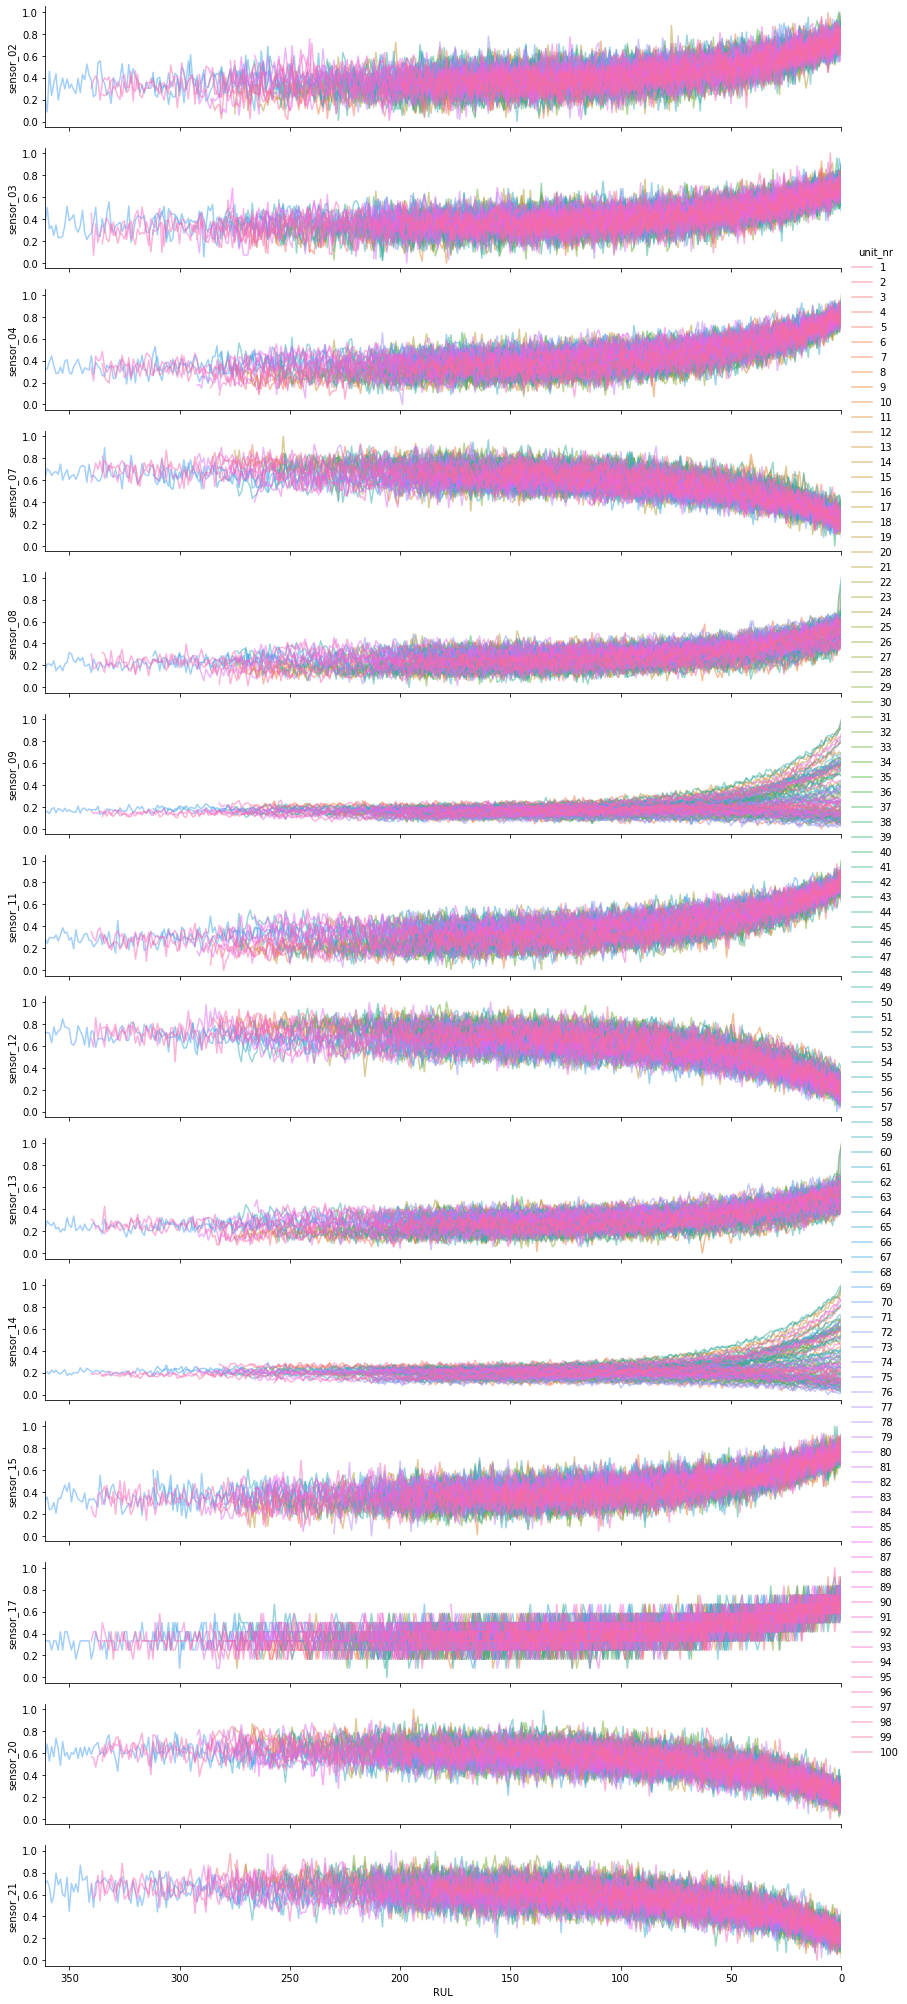

In [11]:
#Features by unit and RUL, before averaging
def plot_grouped_by_RUL(df_sub, leg=True, cols_data=None):

    if cols_data is None: 
        cols = [col for col in df_sub.columns if len(df_sub[col].unique()) > 2]
        cols_data = [col for col in cols if col.startswith('sen') or col.startswith('os')]

    g = sns.PairGrid(data=df_sub, x_vars="RUL", y_vars=cols_data,hue="unit_nr", height=2, aspect=6,)
    g = g.map(plt.plot, alpha=0.5)
    g = g.set(xlim=(df_sub['RUL'].max(),df_sub['RUL'].min()))
    if leg:
        g = g.add_legend()

cols = [c for c in ndf.columns if c.startswith('s') or c in ['RUL', 'unit_nr']]
plot_grouped_by_RUL(df_old[cols].copy())

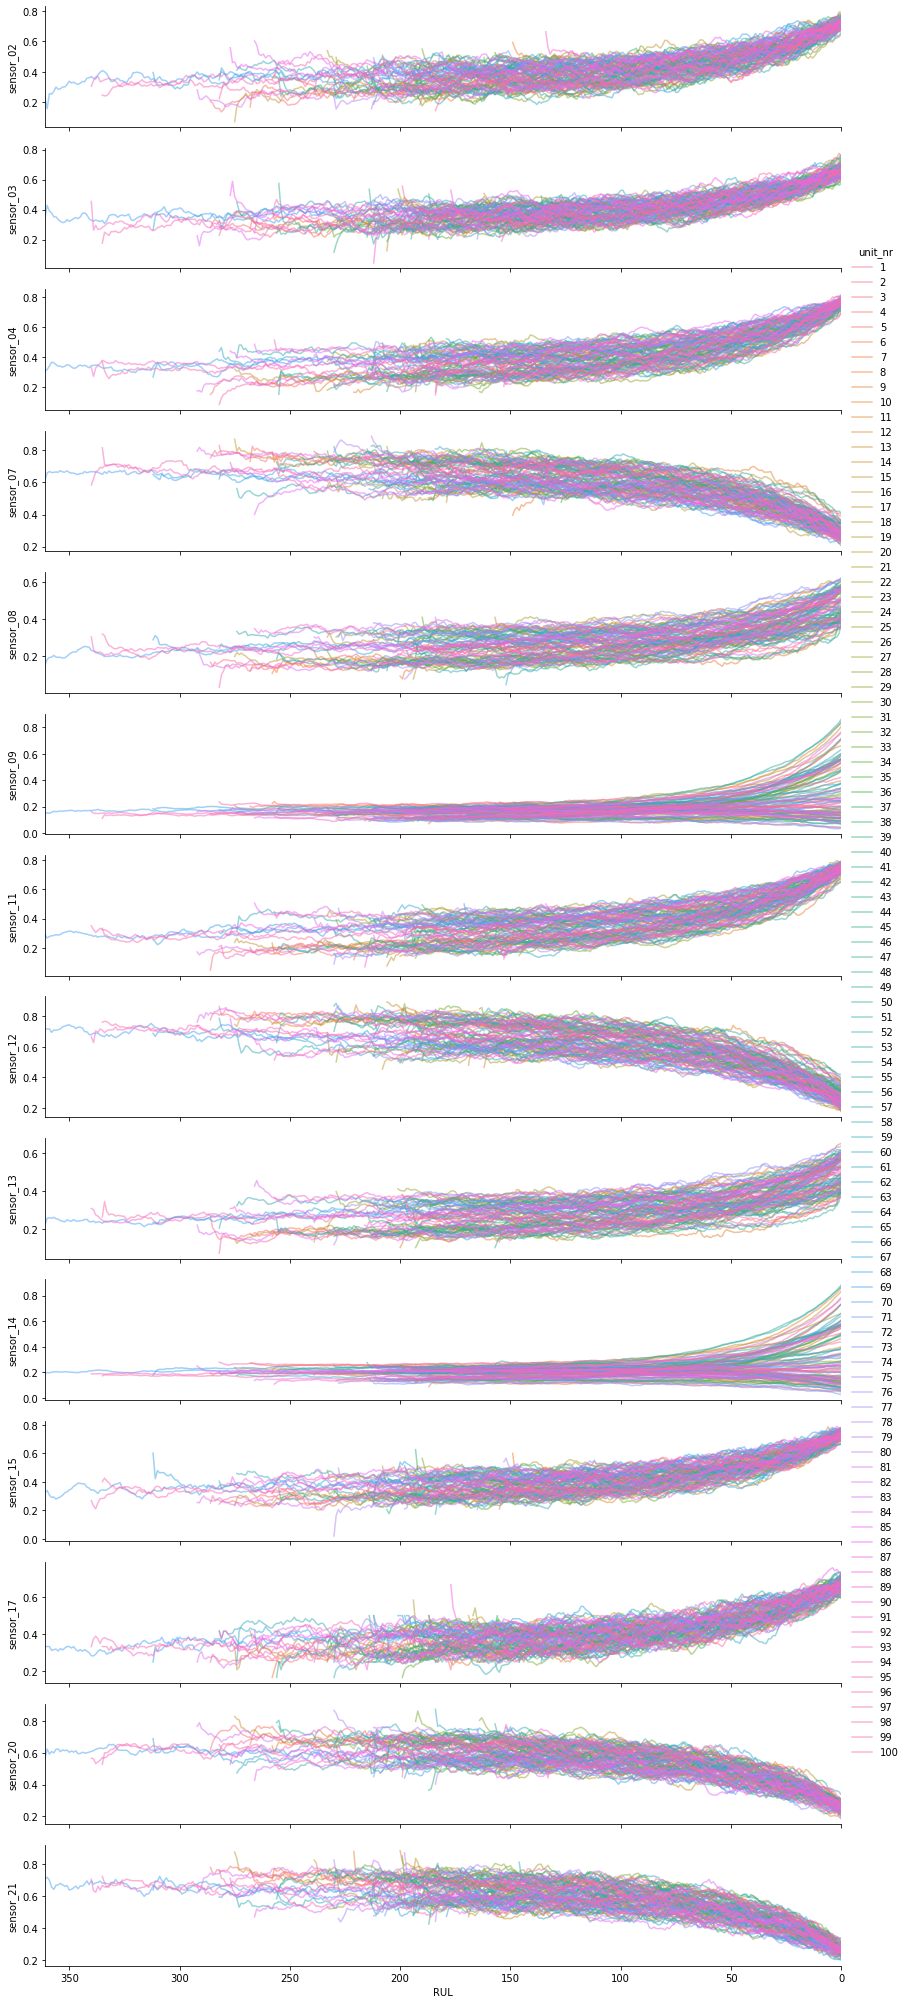

In [12]:
#Features by unit and RUL, after averaging
cols = [c for c in ndf.columns if c.startswith('s') or c in ['RUL', 'unit_nr']]
plot_grouped_by_RUL(ndf[cols].copy())

In [14]:
f_exclude = ['sensor_09', 'sensor_14']
cols_features = [c for c in ndf.columns if c.startswith('s') and c not in f_exclude]

In [15]:
cols_features

['sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_07',
 'sensor_08',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_15',
 'sensor_17',
 'sensor_20',
 'sensor_21']

## 4. Building model

In [16]:
# Splitting the data set into the train set and the test set based on the units

units = ndf['unit_nr'].unique()
n_units = len(ndf['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_test = ndf.loc[ndf['unit_nr'].apply( lambda x: x in units_test )].copy()
df_train = ndf.loc[ndf['unit_nr'].apply( lambda x: x in units_train )].copy()

In [17]:
if list(df_test['unit_nr']) in list(df_train['unit_nr']):
   print('check')

In [18]:
df_test.shape

(4311, 19)

In [23]:
df_train.shape

(16730, 19)

In [19]:
# Defining target variables

train_data = df_train[cols_features].values
train_labels = df_train['RUL'].values

test_data = df_test[cols_features].values
test_labels = df_test['RUL'].values

val_data = df_val[cols_features].values

In [20]:
model = keras.Sequential([
        keras.layers.Dense(24, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(24, activation=tf.nn.relu),
        keras.layers.Dense(24, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
optimizer = tf.train.RMSPropOptimizer(0.001)
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [21]:
# The patience parameter is the amount of epochs to check for improvement
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

EPOCHS=500
train_data2, train_labels2 = shuffle(train_data, train_labels)
history = model.fit(train_data2, train_labels2, epochs=EPOCHS, 
                    verbose=0,
                    validation_data = (test_data, test_labels),
                    callbacks=[early_stop, PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
.............................................

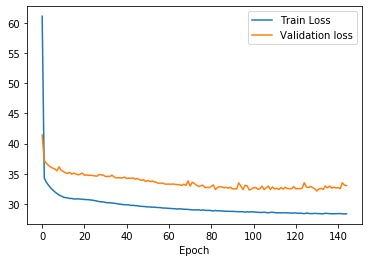

In [22]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation loss')
    plt.legend()


plot_history(history) 

Plot prediciton error distibution

Testing set Mean Abs Error:    33.04
Training set Mean Abs Error:   29.23


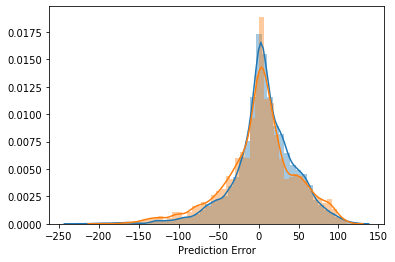

In [23]:
def plot_res(model, test_data, test_labels, train_data, train_labels):
    [loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
    [loss, mae_train] = model.evaluate(train_data, train_labels, verbose=0)
    print("Testing set Mean Abs Error:  {:7.2f}".format(mae))
    print("Training set Mean Abs Error: {:7.2f}".format(mae_train))
    test_predictions = model.predict(test_data).flatten()
    train_predictions = model.predict(train_data).flatten()
    sns.distplot(train_predictions - train_labels)
    sns.distplot(test_predictions - test_labels)
    _ = plt.xlabel("Prediction Error")
    
plot_res(model, test_data, test_labels, train_data, train_labels)

Plot the predicted RULs over the lifecycle of each unit, for the test data set:

C:\Users\Elif\Anaconda4\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Elif\Anaconda4\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


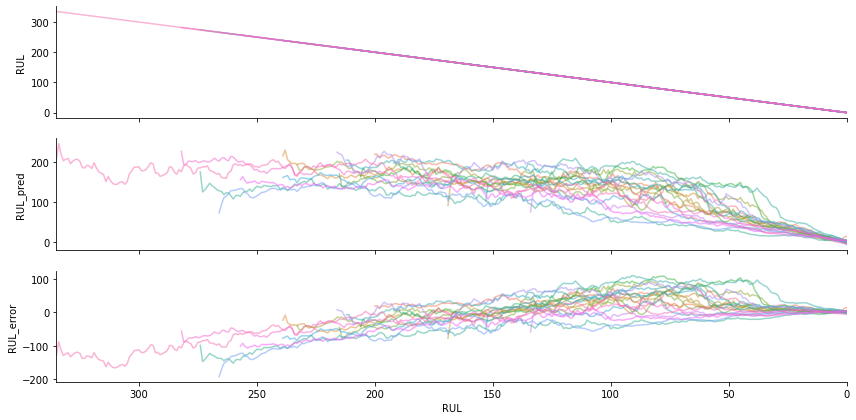

In [24]:
test_predictions = model.predict(test_data).flatten()
tmp = df_test[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = test_predictions - test_labels
tmp.loc[:,'RUL_pred'] = test_predictions

plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

In [25]:
tmp.head()

RUL  unit_nr  RUL_error    RUL_pred
479  178        3 -17.957733  160.042267
480  177        3 -15.028122  161.971878
481  176        3  -8.106705  167.893295
482  175        3   0.331696  175.331696
483  174        3   2.974930  176.974930

Plot the predicted RULs over the lifecycle of each unit, for the training data set:

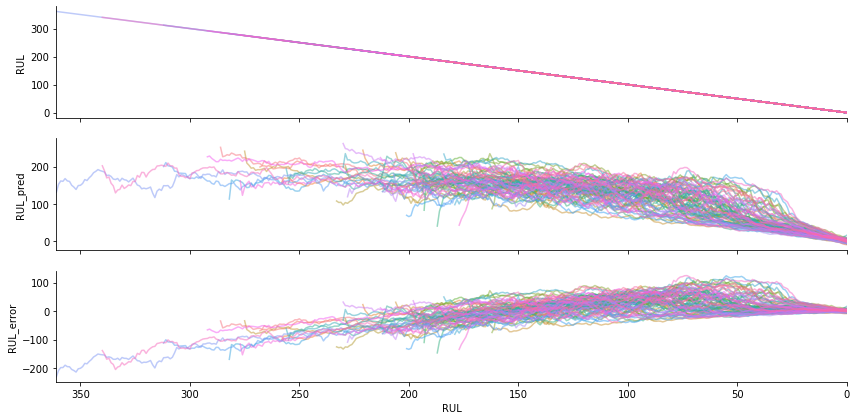

In [26]:
train_predictions = model.predict(train_data).flatten()
tmp = df_train[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = train_predictions - train_labels
tmp.loc[:,'RUL_pred'] = train_predictions

plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

Results

The predicited values for the trained models look ok, and get more reliable, the closer a unit nears the end of its lifecycle. Looking only at the last 30 cycles of the RUL shows:

Testing set Mean Abs Error:     6.44
Training set Mean Abs Error:    7.91


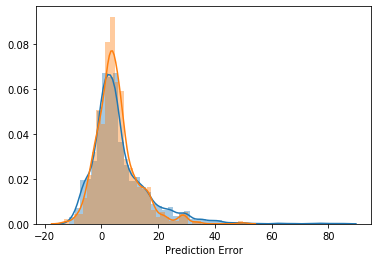

In [27]:
idx_test_end = test_labels < 30.0
idx_train_end = train_labels < 30.0

plot_res(model, test_data[idx_test_end], test_labels[idx_test_end], train_data[idx_train_end], train_labels[idx_train_end])

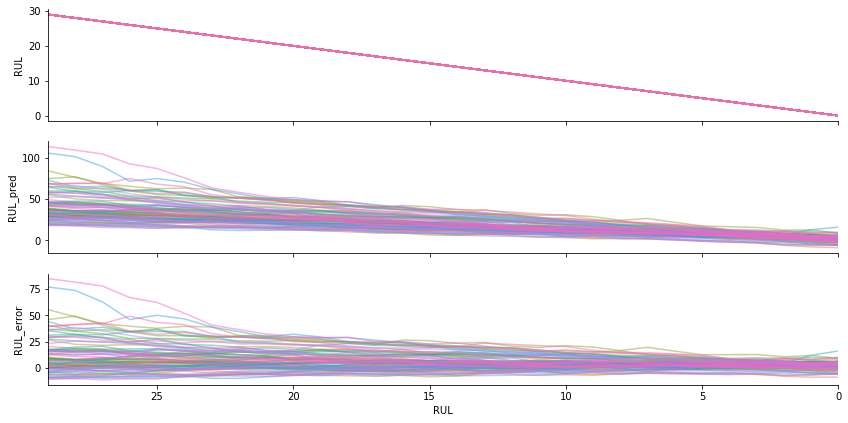

In [36]:
train_predictions = model.predict(train_data).flatten()
tmp = df_train[['RUL', 'unit_nr']]
tmp.loc[:,'RUL_error'] = train_predictions - train_labels
tmp.loc[:,'RUL_pred'] = train_predictions
tmp_30 = tmp[tmp['RUL'] < 30.0]
plot_grouped_by_RUL(tmp_30, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

In [101]:
val_predictions = model.predict(val_data).flatten()
ndf_val.loc[:,'RUL_pred'] = val_predictions
ndf_30 = ndf_val[ndf_val['RUL_pred'] < 30.0]
fail_predicted = ndf_30.unit_nr.unique()
RUL_1['unit_nr']=np.arange(1,101)
fail_true = RUL_1[RUL_1['RUL']<30.0]['unit_nr']
print(fail_true.values)
print(fail_predicted)
for i in range(len(fail_true.values)):
    if fail_true.values[i] in fail_predicted: 
        print("Engine Exists")        
        
print("Number of failed engines predicted : % 3d, Number of failed engines : % 2d" %(len(fail_predicted), len(fail_true))) 

[ 18  20  24  31  34  35  36  37  40  41  42  49  52  53  56  61  64  66
  68  76  81  82  90  92 100]
[  3   5   8  11  14  18  20  24  30  31  33  34  35  36  37  38  40  41
  42  43  45  46  47  49  52  53  56  57  58  61  62  63  64  66  68  76
  77  81  82  84  85  88  89  90  91  92  93  94 100]
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Engine Exists
Number of failed engines predicted :  49, Number of failed engines :  25
